## imports & installations

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
import itertools
import os
from scipy.stats import normaltest
from itertools import groupby
import datetime

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append('/sise/home/shakarch/muscle-formation-regeneration')
sys.path.append(os.path.abspath('..'))

import TimeSeriesAnalysis.analysis.calc_single_cell_properties as calcultator 
import TimeSeriesAnalysis.analysis.utils as utils
import TimeSeriesAnalysis.data_layer.utils as data_utils
import TimeSeriesAnalysis.configuration.consts as consts

## data loading - differentiation scores dataframes

In [2]:
scores_df_s3 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")

scores_df_s2 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")

scores_df_s5 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S5.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S5.pkl")

scores_df_s1 = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S1.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S1.pkl")

Calculate single cell properties

In [3]:
scores_df_s3 = calcultator.get_properties(scores_df_s3, vid_name="S3", actin_vid_path=consts.s_runs["3"]['actin_path'])
scores_df_s2 = calcultator.get_properties(scores_df_s2, vid_name="S2", actin_vid_path=consts.s_runs["2"]['actin_path'])
scores_df_s5 = calcultator.get_properties(scores_df_s5, vid_name="S5", actin_vid_path=consts.s_runs["5"]['actin_path'])
scores_df_s1 = calcultator.get_properties(scores_df_s1, vid_name="S1", actin_vid_path=consts.s_runs["1"]['actin_path'])

In [4]:
scores_df_s3["target"] = 1
scores_df_s2["target"] = 0
scores_df_s5["target"] = 1
scores_df_s1["target"] = 0

scores_df_s3_s2 = pd.concat([scores_df_s3, scores_df_s2])
scores_df_s5_s1 = pd.concat([scores_df_s5, scores_df_s1])

print("#cells s3: ", scores_df_s3["Spot track ID"].nunique(), "#cells s2: ", scores_df_s2["Spot track ID"].nunique())
print("#cells s5: ", scores_df_s5["Spot track ID"].nunique(), "#cells s1: ", scores_df_s1["Spot track ID"].nunique())

#cells s3:  675 #cells s2:  95
#cells s5:  420 #cells s1:  249


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


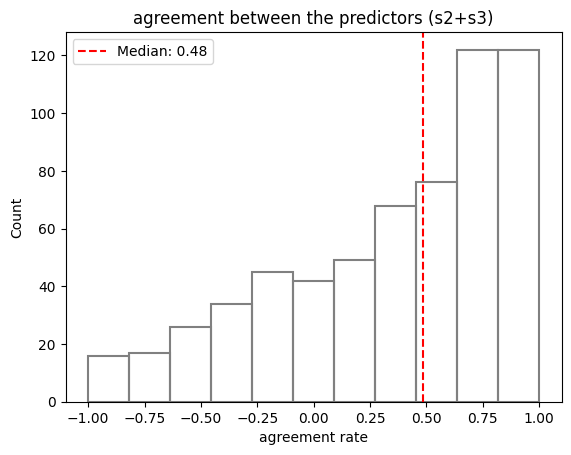

number of cells in the analysis:  692


<Figure size 640x480 with 0 Axes>

In [5]:
def plot_corr_histplot(corr, title, xlabel, color="gray"):
    median = np.nanmedian(corr)
    sns.histplot(corr, fill=False, color=color)    
    plt.axvline(median, color='r', linestyle='dashed', label='Median: {:.2f}'.format(median))

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.savefig(consts.storage_path + f"eps_figs/agreement of both predictors (s2 + s3).eps", format="eps")
    plt.show()
    plt.clf()
    print("number of cells in the analysis: ", len(corr)) 
    return median
    

corr = utils.get_correlation_coefficients(scores_df_s3_s2, (6,13), "score_motility", "score_intensity", rolling_w=6, corr_metric="pearson")
median_corr_s3_s2 = plot_corr_histplot(corr, "agreement between the predictors (s2+s3)", "agreement rate", color="gray")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


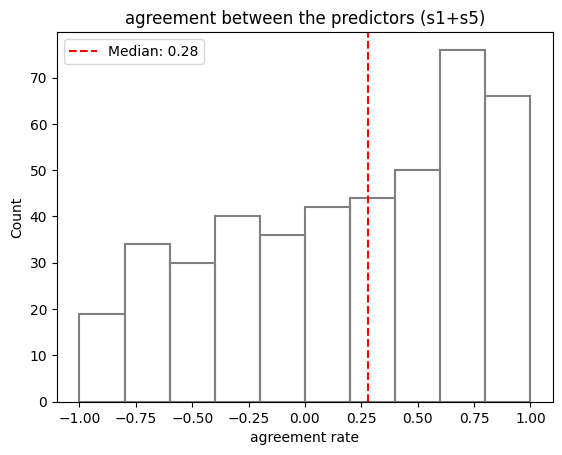

number of cells in the analysis:  529


<Figure size 640x480 with 0 Axes>

In [6]:
corr = utils.get_correlation_coefficients(scores_df_s5_s1, (6,15), "score_motility", "score_intensity", rolling_w=6, corr_metric="pearson")
median_corr_s5_s1 = plot_corr_histplot(corr, "agreement between the predictors (s1+s5)", "agreement rate", color="gray")

In [7]:
def get_cells_by_correlation_rate(data, corr_range, x_property, y_property, rolling_w=1, time=(0,25), corr_metric="pearson"):
    data_copy = data.copy()
    data_copy = data_copy[(data_copy["time"]>=time[0]) & (data_copy["time"]<=time[1])]
    data_copy[x_property] = data_copy[x_property].rolling(rolling_w).mean()
    data_copy[y_property] = data_copy[y_property].rolling(rolling_w).mean()
    corr = data_copy.astype('float64').groupby('Spot track ID')[[x_property, y_property]].corr(method=corr_metric).iloc[0::2][[y_property]]
    condition = (corr[y_property] >= corr_range[0]) & (corr[y_property] <= corr_range[1])

    cell_ids_above_thresh = corr[condition][y_property].reset_index()['Spot track ID']
    
    return data[data["Spot track ID"].isin(cell_ids_above_thresh)]

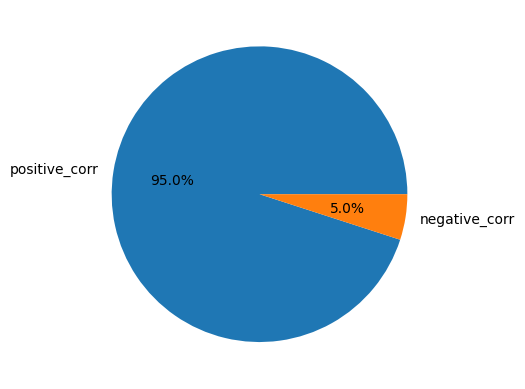

number of cells in the analysis:  602


In [8]:
# see how many cells are above/below the median

positive_corr = get_cells_by_correlation_rate(scores_df_s3_s2, (0, 1), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
negative_corr = get_cells_by_correlation_rate(scores_df_s3_s2, (-1, 0), "score_motility", "score_intensity", rolling_w=6, time=(6,13))

array = [positive_corr["Spot track ID"].nunique(), negative_corr["Spot track ID"].nunique()]
labels = ["positive_corr", "negative_corr"]
plt.pie(array, labels=labels, autopct='%1.1f%%')
plt.show()

print("number of cells in the analysis: ", positive_corr["Spot track ID"].nunique() + negative_corr["Spot track ID"].nunique())

## global exploration

In [9]:
def plot_ecdfplot(data, y_val, color, label, modality):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.ecdfplot(data=data, y=y_val, color=color, complementary=True, label=label)
    med_val = data[y_val].quantile(.5)

    y_special = 0.5
    ax.text(med_val, med_val, f' {med_val:.2f}', ha='left', va='top')
    ax.axvline(0.5, linestyle='--', color='lightgray', lw=2, alpha=0.95)
    plt.ylim((-1,1))
    plt.ylabel("monotonicity rate")
    plt.title("monotonicty rate for cells both predictors highly agreed on (s2 + s3)")
    plt.savefig(consts.storage_path + f"eps_figs/monotonicty rate for cells both predictors (s2 + s3) {modality}.eps", format="eps")
    plt.show()

corr range: (0.48335489864527925, 1)
number of cells in the analysis: 373
motility: normality test p-val=4.032603977469333e-13, mean: 0.495, std: 0.433, median: 0.653, percentage >=0: 85.523 %
intensity: normality test p-val=1.24641542529943e-22, mean: 0.578, std: 0.39, median: 0.725, percentage >=0: 90.08 %


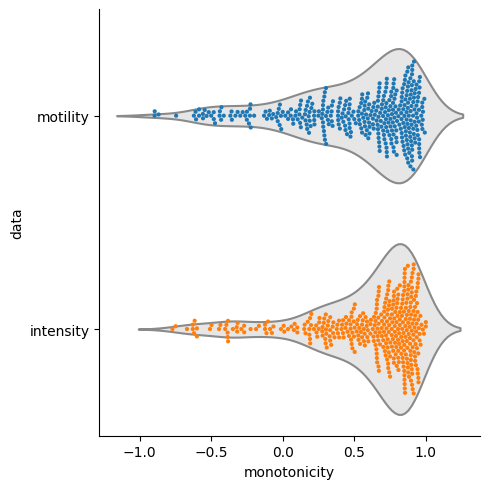

corr range: (-0.2, 0.2)
number of cells in the analysis: 42
motility: normality test p-val=0.06442292421562533, mean: 0.036, std: 0.563, median: 0.031, percentage >=0: 50.0 %
intensity: normality test p-val=0.011541428455636734, mean: 0.474, std: 0.419, median: 0.591, percentage >=0: 88.095 %


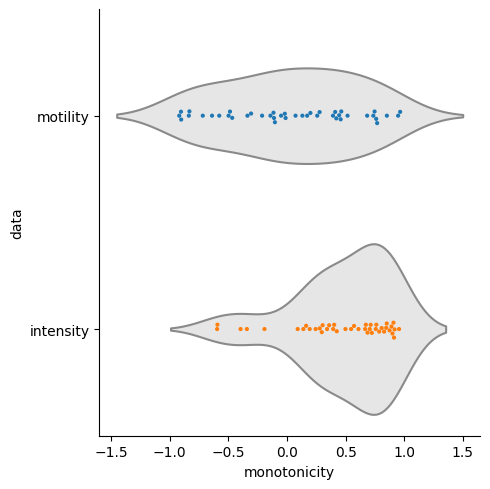

corr range: (-1, -0.48335489864527925)
number of cells in the analysis: 10
motility: normality test p-val=0.37644978932354656, mean: 0.323, std: 0.612, median: 0.428, percentage >=0: 80.0 %
intensity: normality test p-val=0.3618497855663039, mean: 0.32, std: 0.741, median: 0.482, percentage >=0: 70.0 %


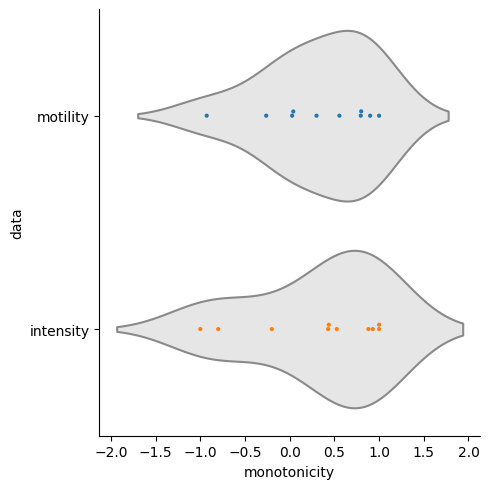

In [10]:
def plot_monotonicity_by_corrlation_range(data, corr_range, mono_rolling=1, consent_rolling=6):
    constent_data = get_cells_by_correlation_rate(data, corr_range, "score_motility", "score_intensity", rolling_w=6, time=(6,13))
    constent_data = calcultator.get_monotonicity(constent_data, "motility", (6,13), rolling_w=mono_rolling)
    constent_data = calcultator.get_monotonicity(constent_data, "intensity", (6,13), rolling_w=mono_rolling)

    utils.plot_violin_distributions(constent_data.drop_duplicates("Spot track ID"), "monotonicity", ["motility", "intensity"], plot_window=False)

print(f"corr range: {(median_corr_s3_s2, 1)}")
plot_monotonicity_by_corrlation_range(scores_df_s3, (median_corr_s3_s2, 1), mono_rolling=1, consent_rolling=6)

print(f"corr range: {(-0.2, 0.2)}")
plot_monotonicity_by_corrlation_range(scores_df_s3, (-0.2, 0.2), mono_rolling=1, consent_rolling=6)

print(f"corr range: {(-1, -median_corr_s3_s2)}")
plot_monotonicity_by_corrlation_range(scores_df_s3_s2, (-1, -median_corr_s3_s2), mono_rolling=1, consent_rolling=6)

In [11]:
scores_df_s3.head(2)

,score_motility,time,Spot frame,Spot track ID,score_intensity,Spot position X,Spot position Y,speed,mean,persistence,local density,target
3976,NaN,0.0,0,1115,NaN,794.409912,962.716553,NaN,331.682617,NaN,6,1
124736,NaN,0.0,0,29615,NaN,760.951782,304.275787,NaN,517.836914,NaN,8,1


corr range: (0.48335489864527925, 1)
number of cells in the analysis: 373
motility: normality test p-val=4.032603977469333e-13, mean: 0.495, std: 0.433, median: 0.653, percentage >=0: 85.523 %
intensity: normality test p-val=1.24641542529943e-22, mean: 0.578, std: 0.39, median: 0.725, percentage >=0: 90.08 %


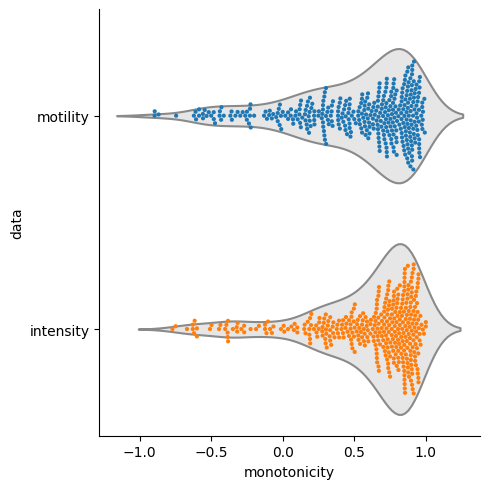

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


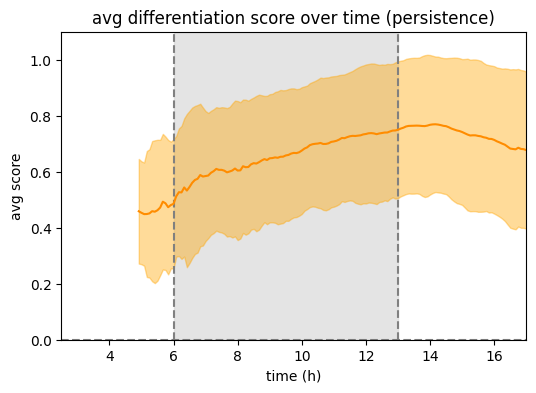

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

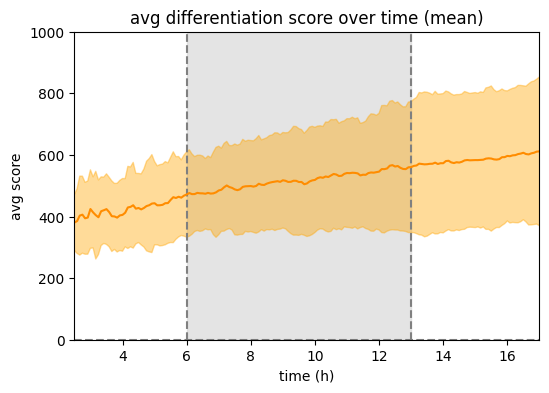

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

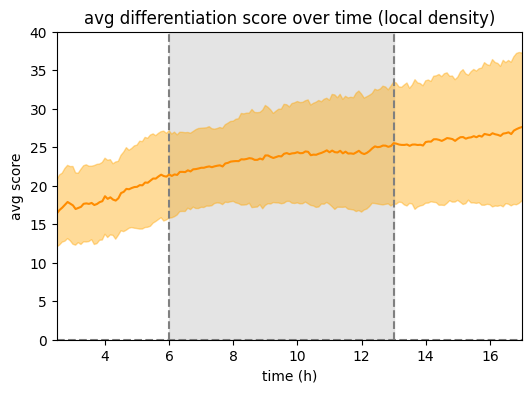

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

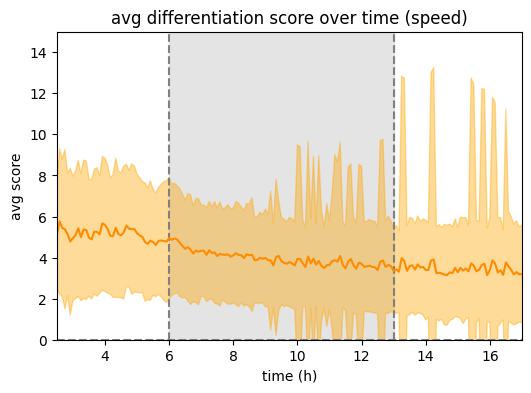

corr range: (-0.2, 0.2)
number of cells in the analysis: 42
motility: normality test p-val=0.06442292421562533, mean: 0.036, std: 0.563, median: 0.031, percentage >=0: 50.0 %
intensity: normality test p-val=0.011541428455636734, mean: 0.474, std: 0.419, median: 0.591, percentage >=0: 88.095 %


<Figure size 640x480 with 0 Axes>

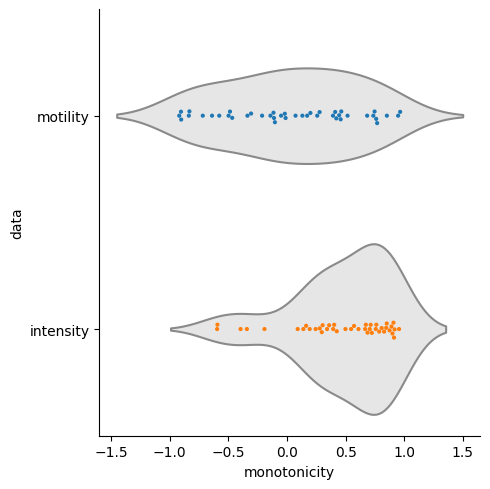

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


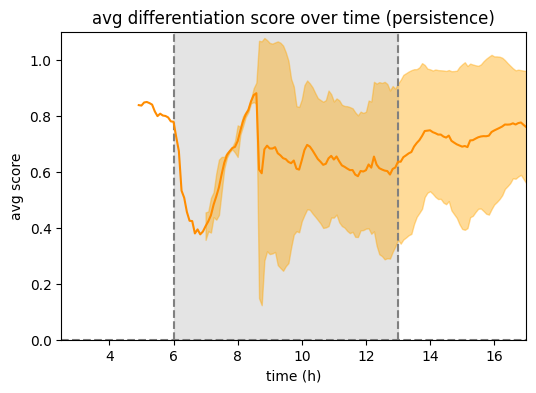

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

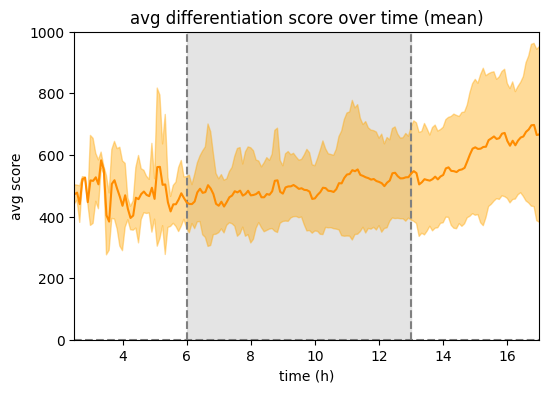

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

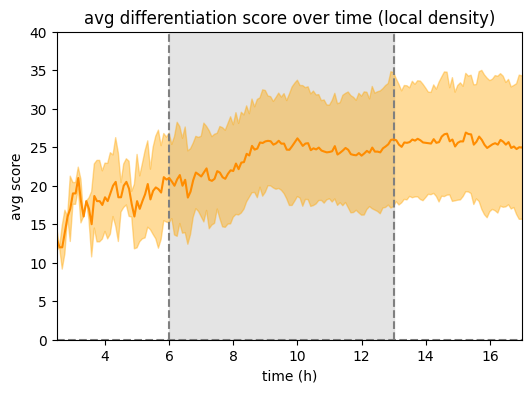

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

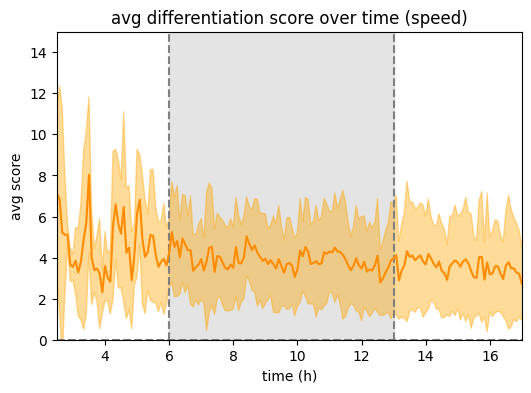

corr range: (-1, -0.48335489864527925)
number of cells in the analysis: 10
motility: normality test p-val=0.37644978932354656, mean: 0.323, std: 0.612, median: 0.428, percentage >=0: 80.0 %
intensity: normality test p-val=0.3618497855663039, mean: 0.32, std: 0.741, median: 0.482, percentage >=0: 70.0 %


<Figure size 640x480 with 0 Axes>

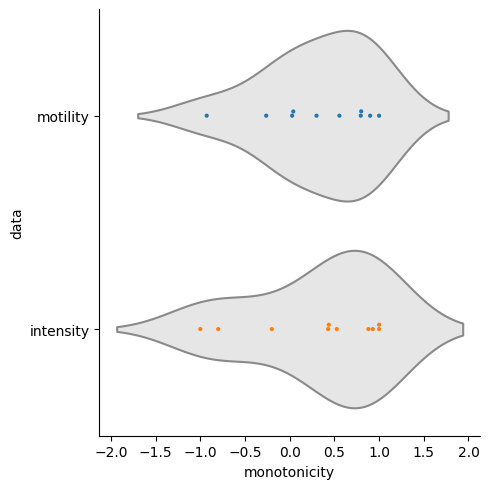

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


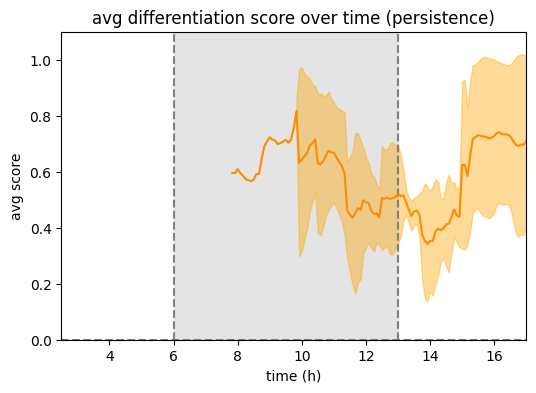

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

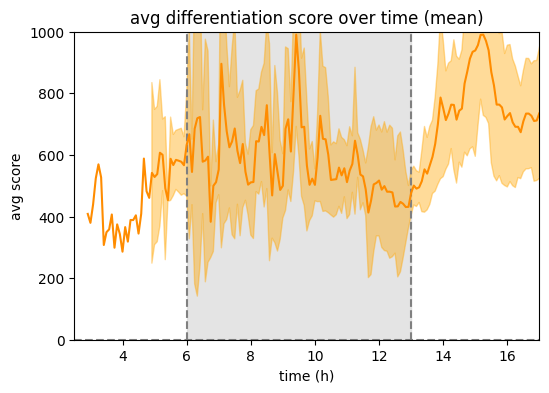

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

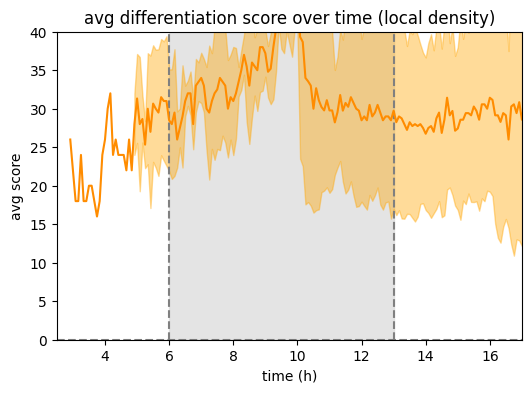

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

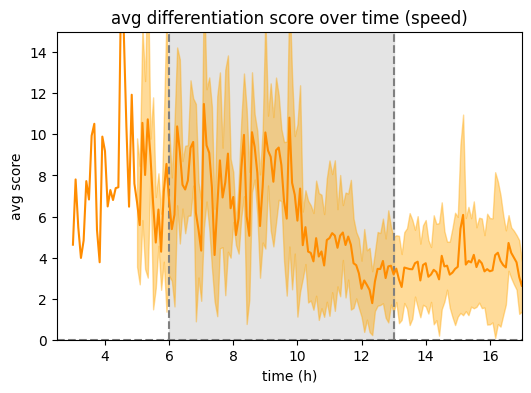

<Figure size 640x480 with 0 Axes>

In [20]:
def plot_by_corrlation_range(data, corr_range, mono_rolling=1, consent_rolling=6):
    constent_data = get_cells_by_correlation_rate(data, corr_range, "score_motility", "score_intensity", rolling_w=6, time=(6,13))

    constent_data = calcultator.get_monotonicity(constent_data, "motility", (6,13), rolling_w=mono_rolling)
    constent_data = calcultator.get_monotonicity(constent_data, "intensity", (6,13), rolling_w=mono_rolling)
    utils.plot_violin_distributions(constent_data.drop_duplicates("Spot track ID"), "monotonicity", ["motility", "intensity"], plot_window=False)
    
    constent_data["score_persistence"] = constent_data["persistence"]
    utils.plot_avg_conf([(constent_data, "ERKi", "DarkOrange","Orange")], "persistence", path="", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(0, 1.1), axhline_val=0)
    
    constent_data["score_mean"] = constent_data["mean"]
    utils.plot_avg_conf([(constent_data, "ERKi", "DarkOrange","Orange")], "mean", path="", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(0, 1000), axhline_val=0)
    
    constent_data["score_local density"] = constent_data["local density"]
    utils.plot_avg_conf([(constent_data, "ERKi", "DarkOrange","Orange")], "local density", path="", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(0, 40), axhline_val=0)
    
    constent_data["score_speed"] = constent_data["speed"]
    utils.plot_avg_conf([(constent_data, "ERKi", "DarkOrange","Orange")], "speed", path="", plot_std=True, time=(6,13), xlim=(2.5, 17), ylim=(0, 15), axhline_val=0)
    

print(f"corr range: {(median_corr_s3_s2, 1)}")
plot_by_corrlation_range(scores_df_s3, (median_corr_s3_s2, 1), mono_rolling=1, consent_rolling=6)

print(f"corr range: {(-0.2, 0.2)}")
plot_by_corrlation_range(scores_df_s3, (-0.2, 0.2), mono_rolling=1, consent_rolling=6)

print(f"corr range: {(-1, -median_corr_s3_s2)}")
plot_by_corrlation_range(scores_df_s3_s2, (-1, -median_corr_s3_s2), mono_rolling=1, consent_rolling=6)

## exploration in the single cell level

In [15]:
df_s3_fused = data_utils.get_scores_df_with_fusion()
scores_df_s3_fused = df_s3_fused.merge(scores_df_s3, how="left", on=["Spot track ID", "Spot frame", "time", "score_motility", "score_intensity", 'Spot position X', 'Spot position Y' ])

In [22]:
fused_high_constent_data = get_cells_by_correlation_rate(scores_df_s3_fused, (median_corr_s3_s2, 1), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
fused_low_constent_data = get_cells_by_correlation_rate(scores_df_s3_fused, (-0.2, 0.2), "score_motility", "score_intensity", rolling_w=6, time=(6,13))
fused_no_constent_data = get_cells_by_correlation_rate(scores_df_s3_fused, (-1, -median_corr_s3_s2), "score_motility", "score_intensity", rolling_w=6, time=(6,13))

In [23]:
fused_high_constent_data["Spot track ID"].nunique(), fused_low_constent_data["Spot track ID"].nunique(), fused_no_constent_data["Spot track ID"].nunique()

(29, 10, 7)

In [12]:
def plot_analysis_by_ranges(data, track_id, ranges, range_by_feature):
    track = data[data["Spot track ID"] == track_id]
    corr = utils.get_correlation_coefficients(track, (6,13), "score_motility", "score_intensity", rolling_w=6, corr_metric="pearson")
    print(track_id)
    print("corr: ", round(corr[0], 3))

    for modality in ["motility", "intensity"]:
        utils.plot_diff_trajectories_single_cells([(track, "ERK")], modality, None , rolling_w=1, x_label="Spot frame")
    try:
        utils.plot_props_by_range(track, "time", ranges)
    except:
        pass
    print("====")

6993
corr:  0.372


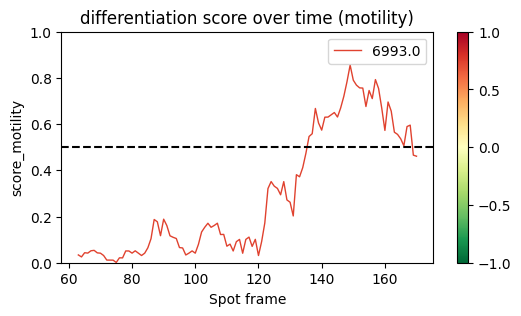

<Figure size 640x480 with 0 Axes>

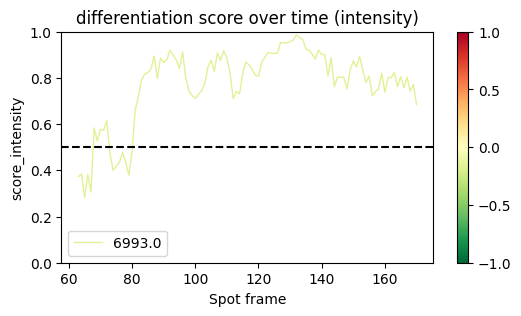

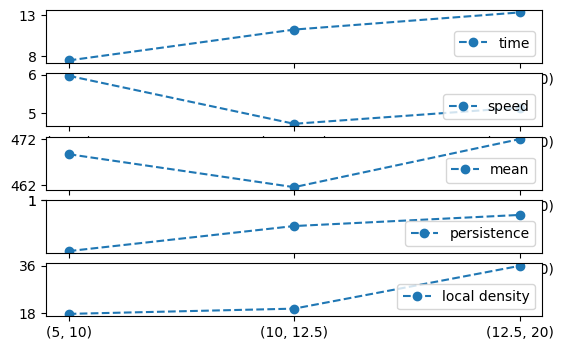

====


In [18]:
plot_analysis_by_ranges(scores_df_s3_fused, 6993, [(5, 10), (10, 12.5), (12.5, 20)], "time")

In [25]:
low_corr_ids = [8662, 20857, 3637]
neg_corr_ids = [6449, 5453, 7127] 

8662
corr:  -0.158


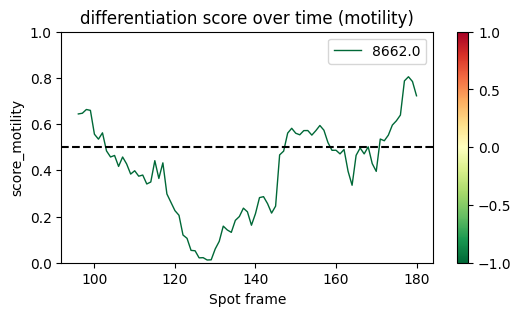

<Figure size 640x480 with 0 Axes>

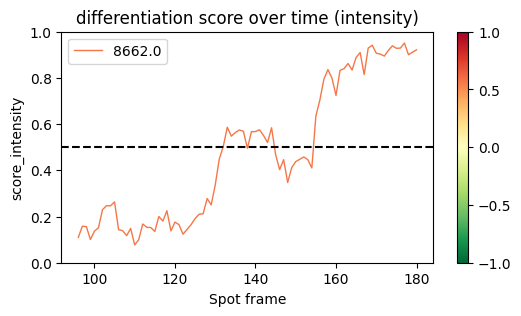

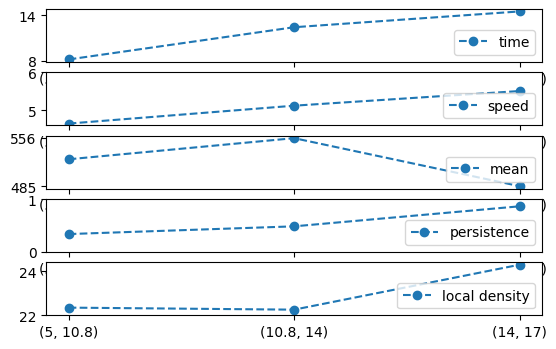

====


In [26]:
plot_analysis_by_ranges(scores_df_s3_fused, 8662, [(5, 10.8), (10.8, 14), (14, 17)], "time")

20857
corr:  -0.052


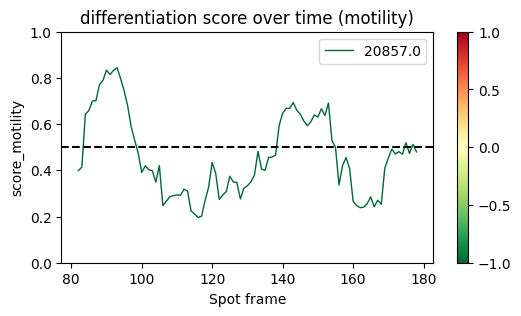

<Figure size 640x480 with 0 Axes>

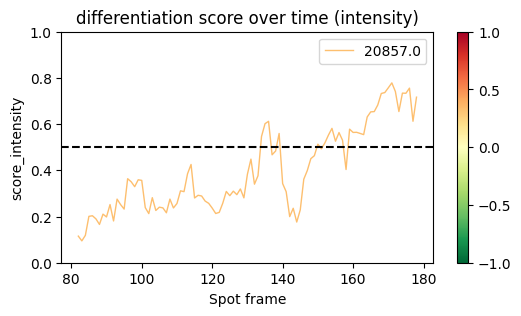

====


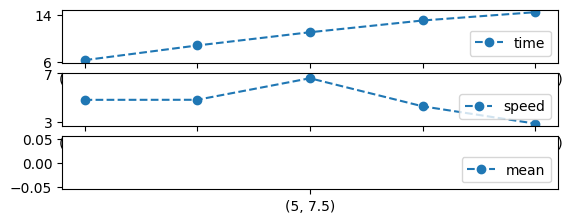

In [27]:
plot_analysis_by_ranges(scores_df_s3_fused, 20857, [(5, 7.5), (7.5, 10), (10, 12), (12, 14), (14, 24)], "time")

3637
corr:  0.107


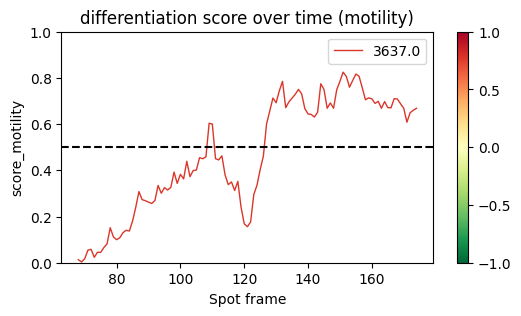

<Figure size 640x480 with 0 Axes>

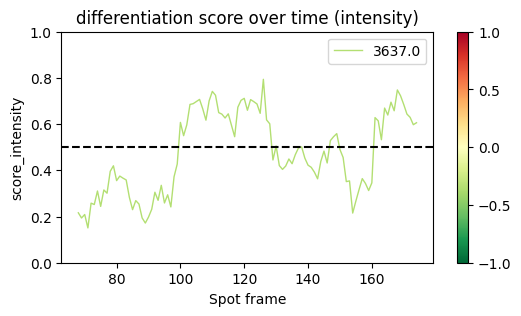

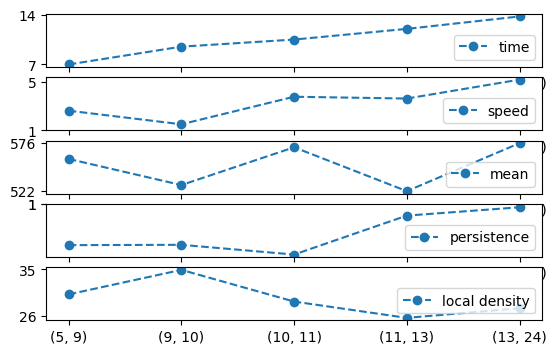

====


In [28]:
plot_analysis_by_ranges(scores_df_s3_fused, 3637, [(5, 9), (9, 10), (10, 11), (11, 13), (13, 24)], "time")

6449
corr:  -0.623


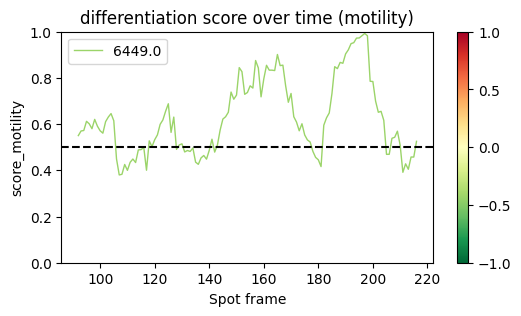

<Figure size 640x480 with 0 Axes>

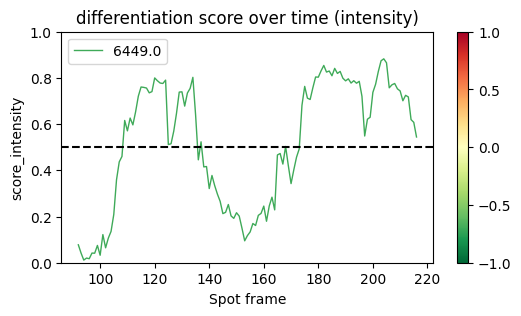

====


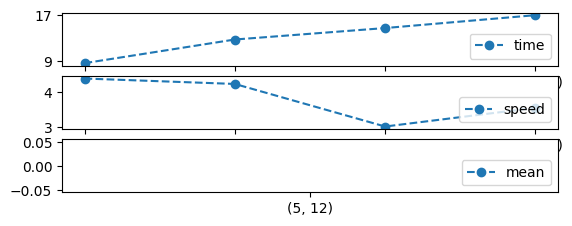

In [29]:
plot_analysis_by_ranges(scores_df_s3_fused, 6449, [(5, 12), (12, 13.5), (13.5, 16), (16, 24)], "time")

5453
corr:  -0.912


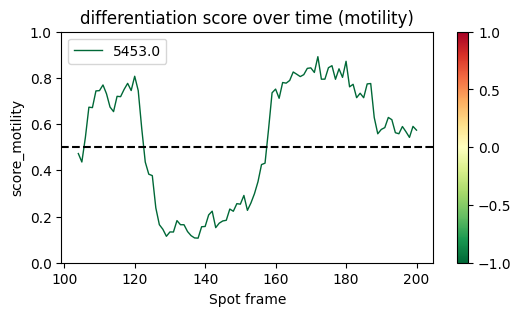

<Figure size 640x480 with 0 Axes>

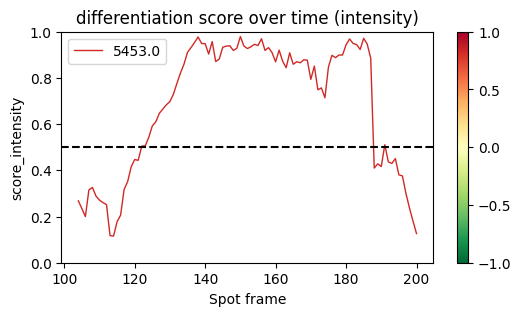

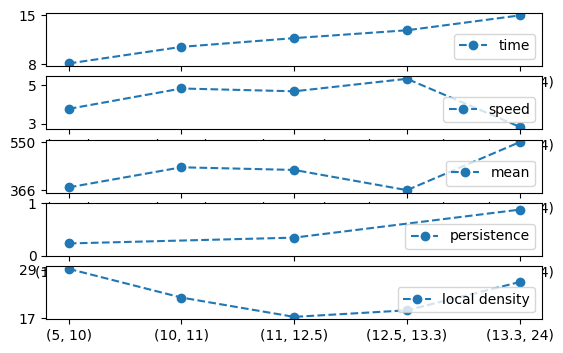

====


In [30]:
plot_analysis_by_ranges(scores_df_s3_fused, 5453, [(5, 10), (10, 11), (11, 12.5), (12.5, 13.3), (13.3, 24)], "time")

7127
corr:  -0.906


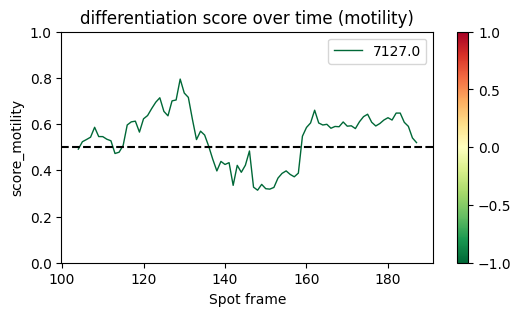

<Figure size 640x480 with 0 Axes>

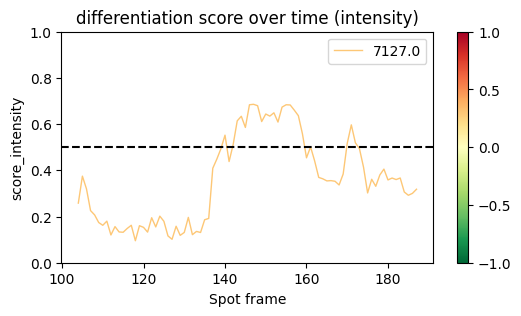

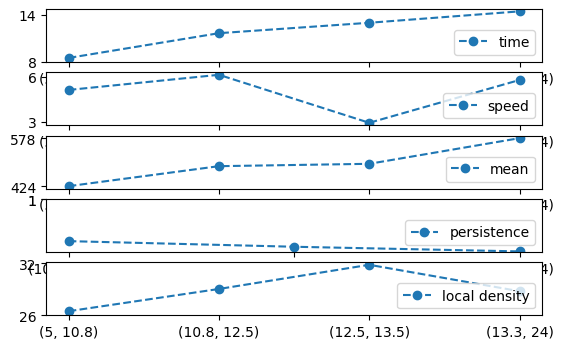

====


In [31]:
plot_analysis_by_ranges(scores_df_s3_fused, 7127, [(5, 10.8), (10.8, 12.5), (12.5, 13.5), (13.3, 24)], "time")